Fails experiments

In [1]:
from pathlib import Path

In [2]:
current_directory = Path.cwd().joinpath("datasets", "today_news")

In [3]:
today_news = current_directory.joinpath("2024-10-15-news.csv")

In [4]:
import pandas as pd

In [5]:
news_df = pd.read_csv(today_news)

In [6]:
model_path = Path.cwd().joinpath("models")

In [7]:
embedding_model_id = "dunzhang/stella_en_400M_v5"

In [8]:
embedding_model_path = model_path.joinpath(embedding_model_id)

In [9]:

transformer_kwargs = {"model_name_or_path": embedding_model_path.__str__(),
                      "trust_remote_code": True,
                      "device": "cpu",
                      "config_kwargs": {"use_memory_efficient_attention": False,
                                        "unpad_inputs": False},
                      "cache_folder": model_path}

In [10]:
transformer_kwargs

{'model_name_or_path': '/Users/esp.py/Projects/Personal/end-to-end-rag/models/dunzhang/stella_en_400M_v5',
 'trust_remote_code': True,
 'device': 'cpu',
 'config_kwargs': {'use_memory_efficient_attention': False,
  'unpad_inputs': False},
 'cache_folder': PosixPath('/Users/esp.py/Projects/Personal/end-to-end-rag/models')}

In [11]:
from sentence_transformers import SentenceTransformer

/Users/esp.py/Projects/Personal/end-to-end-rag/.venv/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [12]:
sentence_transformer_model = SentenceTransformer(
    **transformer_kwargs)

Some weights of the model checkpoint at /Users/esp.py/Projects/Personal/end-to-end-rag/models/dunzhang/stella_en_400M_v5 were not used when initializing NewModel: ['new.pooler.dense.bias', 'new.pooler.dense.weight']
- This IS expected if you are initializing NewModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing NewModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
title_embeddings = sentence_transformer_model.encode(news_df["title"].values.tolist(), show_progress_bar=True)

Batches:   0%|          | 0/3 [00:00<?, ?it/s]/Users/esp.py/Projects/Personal/end-to-end-rag/.venv/lib/python3.10/site-packages/transformers/modeling_utils.py:1141: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
Batches: 100%|██████████| 3/3 [00:09<00:00,  3.23s/it]


In [14]:
title_embeddings.shape

(72, 1024)

In [15]:
from sklearn.cluster import KMeans

In [16]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [89]:
def find_best_estimator(X):
    K_mean_estimators = [
        (f"KMeans_{i}", KMeans(n_clusters=i, random_state=42)) for i in range(2, X.shape[0])]
    pca_estimator = PCA(n_components=X.shape[0])

    best_estimator = None
    best_metric = float("-inf")
    intertias  = []
    for estimator_name, estimator in K_mean_estimators:
        transformed_X = pca_estimator.fit_transform(X)
        estimator.fit(transformed_X)
        labels = estimator.labels_
        score = silhouette_score(
            transformed_X, labels)
        if score > best_metric:
            best_metric = score
            best_estimator = estimator
        intertias.append(estimator.inertia_)
    return best_estimator, intertias

In [90]:
best_estimator, intertias = find_best_estimator(title_embeddings)

In [91]:
best_estimator.inertia_

1418.99951171875

In [92]:
import matplotlib.pyplot as plt

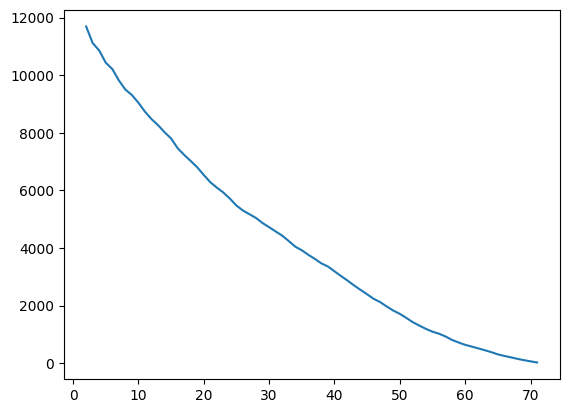

In [93]:
fig, ax = plt.subplots()
ax.plot(range(2, title_embeddings.shape[0]), intertias)

We can see that the shiloulette score does never reach 1, the maximum I can get is 0.12, which indicate that all my cluster a overlaping and k mean does not perform very well here. Let me a hierachical clustering approach.

In [21]:
from sklearn.metrics import silhouette_samples

In [22]:
sample_silhouette_values = silhouette_samples(title_embeddings, best_estimator.labels_)

HDBSCan

In [23]:
import hdbscan

In [55]:
clustered = hdbscan.HDBSCAN(min_cluster_size=6, min_samples=3, cluster_selection_epsilon=0.75).fit(title_embeddings)

In [56]:
clustered.labels_

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1,  0, -1, -1, -1,
       -1, -1, -1,  0,  1,  1, -1, -1, -1, -1, -1,  1,  0, -1,  0, -1,  1,
       -1,  1, -1,  1, -1, -1,  1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1,  1, -1, -1, -1,  0, -1,  0,  1,  0,  1, -1,  1,
       -1, -1, -1, -1])

Hiearchical clustering

In [60]:
from sklearn.neighbors import kneighbors_graph

connectivity = kneighbors_graph(title_embeddings, n_neighbors=10, include_self=False, metric="cosine")

In [63]:
from sklearn.cluster import AgglomerativeClustering
import time

In [95]:
similarities = sentence_transformer_model.similarity(title_embeddings, title_embeddings)

In [96]:
cosine_distance = 1 - similarities

In [181]:
print("Compute structured hierarchical clustering...")
st = time.time()
agglomerative = AgglomerativeClustering(connectivity=connectivity,
                                        linkage="complete",
                                        metric="cosine",
                                        n_clusters=6)
                                        
agglomerative.fit(title_embeddings)
mean_shilouette_score = silhouette_score(title_embeddings, agglomerative.labels_)
elapsed_time = time.time() - st
label = agglomerative.labels_

Compute structured hierarchical clustering...


In [182]:
label

array([0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 5, 0, 0,
       1, 0, 0, 0, 2, 0, 0, 0, 4, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 0])

In [183]:
news_df["labels_agglomerative"] = label

In [184]:
def analyse_embeddings(dataframe, embeddings, index, label_column="labels"):
    """ take an matrix of embeddings, and the labels.
    for each label compute the cosine similarity of document with that label.
    """
    document_in_index = dataframe.query(f"{label_column} == {index}")
    with pd.option_context('display.max_colwidth', None):
        display(document_in_index.title)
    document_index = document_in_index.index
    vectors = embeddings[document_index]
    return sentence_transformer_model.similarity(vectors,  vectors)

In [188]:
analyse_embeddings(news_df, title_embeddings, 0, "labels_agglomerative")

0                                                                                           Présence remarquée de l’ANAPI à la 14ème édition du Forum «EuropAfrica Investment» à Bruxelles
1                                                                                              Mai-Ndombe : le gouvernement provincial publié, aucune femme nommée ministre | Actualite.cd
4                                                                                              Elim/CAN 2025 : Toujours aussi poussifs, les Léopards font le strict minimum | Actualite.cd
5                                                                                                                  Foot – Éliminatoires CAN 2025 : Troisième victoire de suite pour la RDC
7     Matadi : le maire de la ville a comparu comme renseignant au procès du policier qui a ouvert le feu sur des élèves qui réclamaient la fin de la grève des enseignants | Actualite.cd
8                                                                

tensor([[1.0000, 0.4427, 0.4753,  ..., 0.4963, 0.4838, 0.5261],
        [0.4427, 1.0000, 0.5547,  ..., 0.5234, 0.4849, 0.5301],
        [0.4753, 0.5547, 1.0000,  ..., 0.4628, 0.6724, 0.5213],
        ...,
        [0.4963, 0.5234, 0.4628,  ..., 1.0000, 0.5179, 0.5628],
        [0.4838, 0.4849, 0.6724,  ..., 0.5179, 1.0000, 0.5042],
        [0.5261, 0.5301, 0.5213,  ..., 0.5628, 0.5042, 1.0000]])

In [175]:
news_df.query("labels_agglomerative == 0")

,Unnamed: 0,content,title,posted_at,url,labels,labels_db_scan,labels_agglomerative
2,2,"VODACASH S.A, filiale de Vodacom Congo (RDC) S...",Partenariat stratégique entre VODACASH et la S...,2024-10-10 00:00:00,https://econewsrdc.com/partenariat-strategique...,3,-1,0
3,3,"octobre 10, 2024 Kinshasa- Financement des tra...",Kinshasa- Financement des travaux du projet 3 ...,2024-10-10 00:00:00,https://depeche.cd/2024/10/10/kinshasa-finance...,1,-1,0
6,6,"octobre 10, 2024 Allemagne : “Le Président Tsh...",Allemagne : “Le Président Tshisekedi a déjà fa...,2024-10-10 00:00:00,https://depeche.cd/2024/10/10/allemagne-le-pre...,11,-1,0
14,14,La Fédération de la République Démocratique du...,Tennis: La FRDCT participe à l’Assemblée Génér...,2024-10-10 14:54:00,https://actualite.cd/2024/10/10/tennis-la-frdc...,4,-1,0
21,21,Fabriqués par des ex-kuluna devenus bâtisseurs...,Jacquemain Shabani remet officiellement à 15 c...,2024-10-10 07:34:37,https://actu30.cd/2024/10/jacquemain-shabani-r...,1,-1,0
23,23,"Cet événement, organisé par Louise Nzanga Rama...",RDC : Judith Suminwa renforce les liens avec l...,2024-10-10 11:56:44,https://actu30.cd/2024/10/rdc-judith-suminwa-r...,11,-1,0
36,36,Dans un mémorandum adressé au président de l'A...,Dossier forage : l'Assemblée nationale appelée...,2024-10-10 00:00:00,https://www.mediacongo.net/article-actualite-1...,7,-1,0
38,38,En séjour en Allemagne dans le cadre de la con...,Allemagne : Judith Suminwa échange avec la dia...,2024-10-10 00:00:00,https://www.mediacongo.net/article-actualite-1...,11,-1,0
44,44,Les médecins du syndicat libre des médecins on...,Santé publique : les médecins du syndicat libr...,2024-10-10 00:00:00,https://www.mediacongo.net/article-actualite-1...,2,-1,0
57,57,Le cadastre minier (CAMI) a organisé la troisi...,Mines : Kizito Pakabomba veut assainir les min...,2024-10-10 20:26:00,https://actualite.cd/2024/10/10/mines-kizito-p...,1,-1,0


In [77]:
import numpy as np

In [80]:
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(title_embeddings)

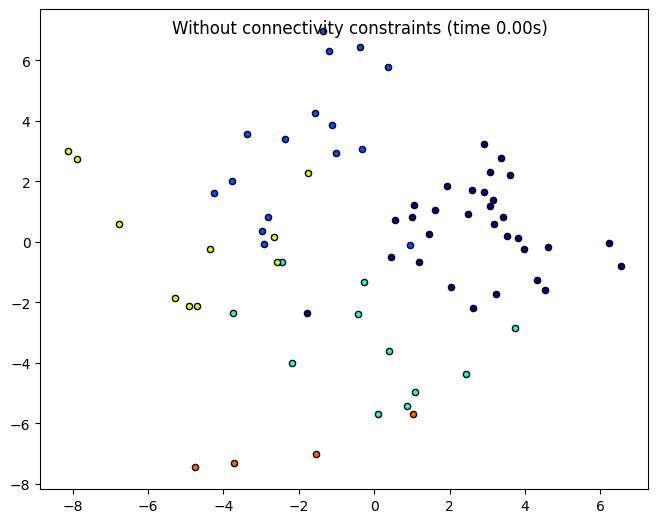

In [84]:
import matplotlib.pyplot as plt

fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.set_position([0, 0, 0.95, 1])
for l in np.unique(label):
    ax1.scatter(
        pca_embeddings[label == l, 0],
        pca_embeddings[label == l, 1],
        color=plt.cm.jet(float(l) / np.max(label + 1)),
        s=20,
        edgecolor="k",
    )
_ = fig1.suptitle(
    f"Without connectivity constraints (time {elapsed_time:.2f}s)")